Part 1: Load Real-CATS Ethereum Data

In [3]:
!pip install torch==2.0.0
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html


In [4]:
from google.colab import drive
drive.mount('/content/drive')

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

if device == 'cuda':
   !pip install torch-scatter torch-sparse torch-geometric torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
else:
    !pip install torch-scatter torch-sparse torch-geometric torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

import os
path = '/content/drive/My Drive/REAL-CATS'

import pandas as pd
ce = pd.read_csv(os.path.join(path, "CE.tsv"), sep="\t")
be = pd.read_csv(os.path.join(path, "BE.tsv"), sep="\t")
print("Criminal samples:", len(ce))
print("Benign samples:", len(be))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Criminal samples: 12591
Benign samples: 16020


In [5]:
import os
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from itertools import combinations
from collections import defaultdict
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
ce["label"] = 1
be["label"] = 0

df = pd.concat([ce, be], ignore_index=True).dropna(subset=["address"])
df = df.drop_duplicates(subset="address").reset_index(drop=True)
df["node_id"] = range(len(df))
addr2idx = dict(zip(df["address"], df["node_id"]))

Part 2: Construct Token Interaction Graph

In [7]:
ti_b = pd.read_csv(os.path.join(path, "TI_B.tsv"), sep="\t")
ti_m = pd.read_csv(os.path.join(path, "TI_M.tsv"), sep="\t")
ti_b.columns = ti_b.columns.str.strip()
ti_m.columns = ti_m.columns.str.strip()
ti = pd.concat([ti_b, ti_m], ignore_index=True).dropna(subset=["Address"])

addr_contract_dict = defaultdict(set)
for _, row in ti.iterrows():
    address = row["Address"]
    if address not in addr2idx:
        continue
    for col in ["ERC20", "ERC1155"]:
        if col in row and isinstance(row[col], str):
            for item in row[col].split(","):
                if ":" in item:
                    contract_id = item.split(":")[0].strip()
                    if contract_id.isdigit():
                        addr_contract_dict[address].add(contract_id)

print(f"Number of addresses with token interactions: {len(addr_contract_dict)}")

contract_to_addrs = defaultdict(set)
for addr, contracts in addr_contract_dict.items():
    for c in contracts:
        contract_to_addrs[c].add(addr)

edge_set = set()
for addr_set in contract_to_addrs.values():
    addr_list = [a for a in addr_set if a in addr2idx]
    if len(addr_list) > 800:
        continue
    for a, b in combinations(addr_list, 2):
        edge_set.add((addr2idx[a], addr2idx[b]))
        edge_set.add((addr2idx[b], addr2idx[a]))

print(f"Number of token contracts: {len(contract_to_addrs)}")
print(f"Total number of edges: {len(edge_set)}")

edge_index = torch.tensor(list(edge_set), dtype=torch.long).permute(1, 0)

Number of addresses with token interactions: 20024
Number of token contracts: 139565
Total number of edges: 9801002


Part 3: Node Feature and Label Preparation

In [6]:
!pip install numpy

In [8]:
feature_cols = df.select_dtypes(include=["float64", "int64"]).columns
x_raw = df[feature_cols].fillna(0.0).values
x = torch.tensor(StandardScaler().fit_transform(x_raw), dtype=torch.float)
y = torch.tensor(df["label"].values, dtype=torch.long)

num_nodes = len(df)
train_idx, test_idx = train_test_split(df.index, test_size=0.2, stratify=y, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, stratify=y[train_idx], random_state=42)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

data = Data(x=x, edge_index=edge_index, y=y,
            train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

print(data)

Data(x=[28611, 48], edge_index=[2, 9801002], y=[28611], train_mask=[28611], val_mask=[28611], test_mask=[28611])


Part 4: Define Graph Convolutional Network

In [9]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

Part 5: Train and Evaluate

In [10]:
def train_and_evaluate(data, device='cuda' if torch.cuda.is_available() else 'cpu'):
    print(f"Using device: {device}")
    model = GCN(in_channels=data.x.shape[1], hidden_channels=64, out_channels=2).to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    best_val_acc = 0
    best_model_state = None

    for epoch in range(1, 101):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        _, pred = out[data.val_mask].max(dim=1)
        val_acc = accuracy_score(data.y[data.val_mask].cpu(), pred.cpu())

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f}")

    model.load_state_dict(best_model_state)
    model.eval()
    out = model(data)
    _, pred = out[data.test_mask].max(dim=1)
    y_true = data.y[data.test_mask].cpu()
    y_pred = pred.cpu()

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print("\nTest Set Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    return model, acc, f1, cm

Part 6: Train the GCN and Visualize Performance

Using device: cuda
Epoch 001 | Loss: 0.7574 | Val Acc: 0.4467
Epoch 002 | Loss: 0.6436 | Val Acc: 0.6640
Epoch 003 | Loss: 0.5635 | Val Acc: 0.7969
Epoch 004 | Loss: 0.4971 | Val Acc: 0.8440
Epoch 005 | Loss: 0.4470 | Val Acc: 0.8626
Epoch 006 | Loss: 0.4062 | Val Acc: 0.8770
Epoch 007 | Loss: 0.3756 | Val Acc: 0.8884
Epoch 008 | Loss: 0.3500 | Val Acc: 0.8895
Epoch 009 | Loss: 0.3288 | Val Acc: 0.8941
Epoch 010 | Loss: 0.3131 | Val Acc: 0.8945
Epoch 011 | Loss: 0.3000 | Val Acc: 0.8965
Epoch 012 | Loss: 0.2890 | Val Acc: 0.8956
Epoch 013 | Loss: 0.2791 | Val Acc: 0.8967
Epoch 014 | Loss: 0.2710 | Val Acc: 0.8991
Epoch 015 | Loss: 0.2636 | Val Acc: 0.9006
Epoch 016 | Loss: 0.2589 | Val Acc: 0.9010
Epoch 017 | Loss: 0.2543 | Val Acc: 0.9019
Epoch 018 | Loss: 0.2508 | Val Acc: 0.9041
Epoch 019 | Loss: 0.2475 | Val Acc: 0.9032
Epoch 020 | Loss: 0.2440 | Val Acc: 0.9032
Epoch 021 | Loss: 0.2421 | Val Acc: 0.9041
Epoch 022 | Loss: 0.2399 | Val Acc: 0.9035
Epoch 023 | Loss: 0.2372 | Val Acc:

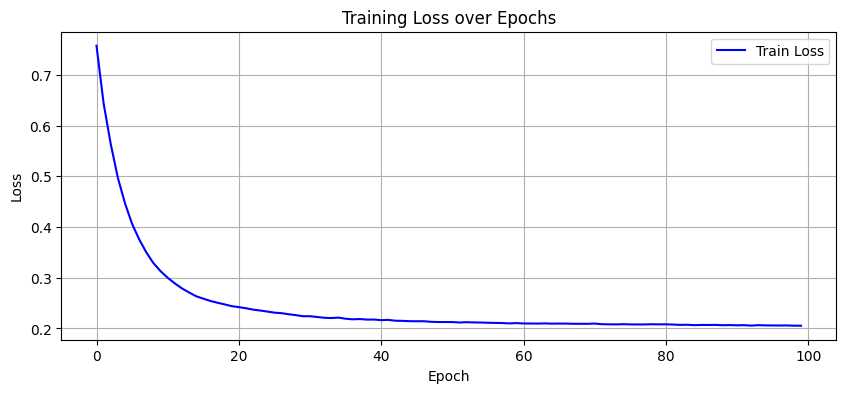

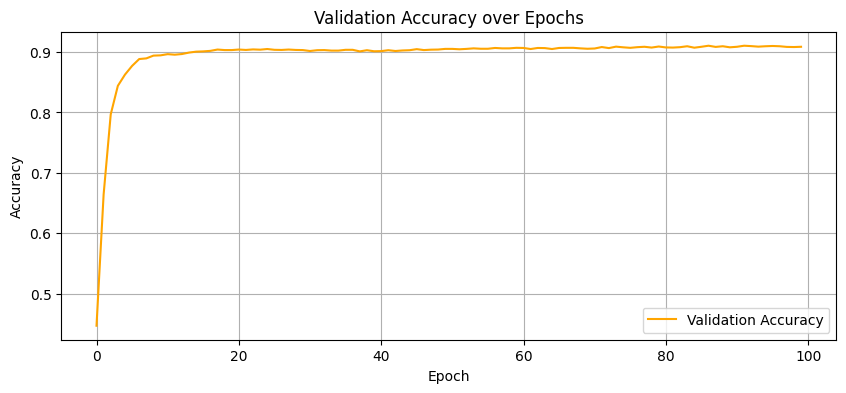

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def train_and_evaluate(data, device='cuda' if torch.cuda.is_available() else 'cpu'):
    print(f"Using device: {device}")
    model = GCN(in_channels=data.x.shape[1], hidden_channels=64, out_channels=2).to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    best_val_acc = 0
    best_model_state = None
    history = {"loss": [], "val_acc": []}

    for epoch in range(1, 101):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        _, pred = out[data.val_mask].max(dim=1)
        val_acc = accuracy_score(data.y[data.val_mask].cpu(), pred.cpu())

        history["loss"].append(loss.item())
        history["val_acc"].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f}")

    # Load best model for final evaluation
    model.load_state_dict(best_model_state)
    model.eval()
    out = model(data)
    _, pred = out[data.test_mask].max(dim=1)
    y_true = data.y[data.test_mask].cpu()
    y_pred = pred.cpu()

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print("\nFinal Test Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    return model, acc, f1, cm, history

# Start training
model, acc, f1, cm, history = train_and_evaluate(data)

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(history["loss"], label="Train Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 4))
plt.plot(history["val_acc"], label="Validation Accuracy", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.grid(True)
plt.legend()
plt.show()

Part 7: Visualize Model Outputs

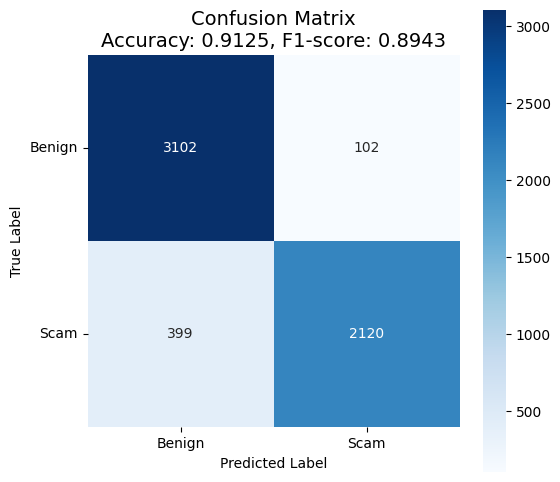

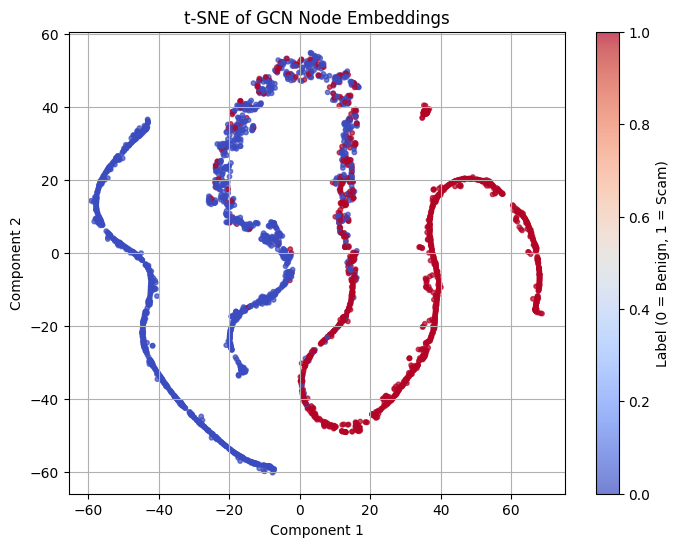

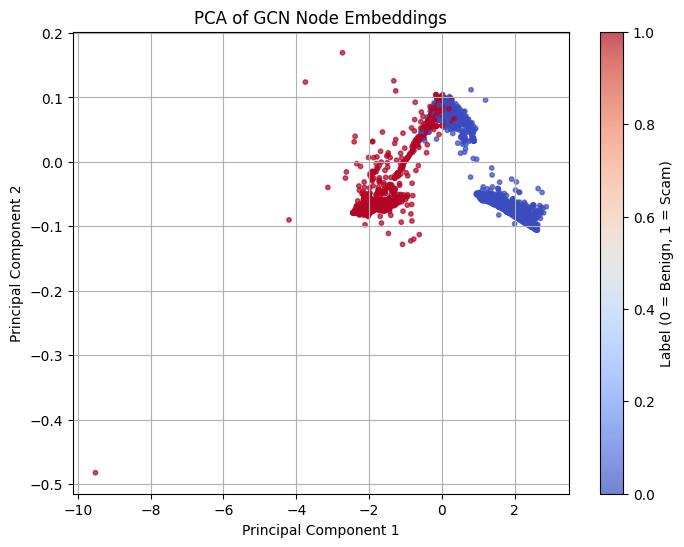

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import torch
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# 1. Confusion Matrix
def plot_confusion_matrix(cm, acc, f1):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", square=True, cbar=True)
    plt.title(f"Confusion Matrix\nAccuracy: {acc:.4f}, F1-score: {f1:.4f}", fontsize=14)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks([0.5, 1.5], ["Benign", "Scam"])
    plt.yticks([0.5, 1.5], ["Benign", "Scam"], rotation=0)
    plt.show()

plot_confusion_matrix(cm, acc, f1)


@torch.no_grad()
def visualize_tsne(model, data, sample_size=3000):
    model.eval()
    model = model.to("cpu")
    data = data.to("cpu")
    out = model(data)
    embeddings = out.detach().numpy()
    labels = data.y.numpy()

    if sample_size < len(embeddings):
        idx = torch.randperm(len(embeddings))[:sample_size]
        embeddings = embeddings[idx]
        labels = labels[idx]

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init="pca")
    reduced = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="coolwarm", s=10, alpha=0.7)
    plt.colorbar(label="Label (0 = Benign, 1 = Scam)")
    plt.title("t-SNE of GCN Node Embeddings")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

visualize_tsne(model, data)


@torch.no_grad()
def visualize_pca(model, data, sample_size=3000):
    model.eval()
    model = model.to("cpu")
    data = data.to("cpu")
    out = model(data)
    embeddings = out.detach().numpy()
    labels = data.y.numpy()

    if sample_size < len(embeddings):
        idx = torch.randperm(len(embeddings))[:sample_size]
        embeddings = embeddings[idx]
        labels = labels[idx]

    embeddings = StandardScaler().fit_transform(embeddings)

    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="coolwarm", s=10, alpha=0.7)
    plt.colorbar(label="Label (0 = Benign, 1 = Scam)")
    plt.title("PCA of GCN Node Embeddings")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.show()

visualize_pca(model, data)